<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Predicting Movie Box Office Revenue (Part 2 - Data Cleaning and EDA)

## Table of Contents

- [Import libraries](#Import-libraries)
- [Data Formatting](#Data-Formatting)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning-2](#Data-Cleaning-2)
- [Export cleaned dataset](#Export-cleaned-dataset)

## Import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from ast import literal_eval
import json
import math

#set notebook parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 60)

In [2]:
#import datasets
movies = pd.read_csv("../data/movies_scraped.csv", lineterminator='\n')
credits = pd.read_csv('../data/credits_scraped.csv')

In [3]:
print("movies:", movies.shape)
print("credits:", credits.shape)

movies: (9998, 29)
credits: (9999, 3)


## Data Formatting

#### Merge datasets

In [4]:
df = pd.merge(movies, credits, how='left', left_on='id', right_on='id')

#### Json format to python

In [5]:
type(df['genres'][0])

str

Some of the columns were originally in the json format but were imported as strings due to csv file formatting. We will convert these column values to dictionaries.

In [6]:
json_cols = ['genres','production_companies','production_countries','spoken_languages','cast','crew']

In [7]:
#define function to convert string to dict format
def text_to_dict(df, cols):

    for col in cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else literal_eval(x))
    return df

In [8]:
df = text_to_dict(df, json_cols)

#### Datetime formatting

In [9]:
df['release_date'] = pd.to_datetime(df['release_date'])

## Data Cleaning

#### Drop columns where target `revenue` column is 0

In [10]:
df = df[df['revenue']!=0]
df.shape

(5115, 31)

#### Drop irrelevant columns

A total of 31 features were collected when scraping for movie details and movie credits. Some of these features would not be relevant for our project and hence we will drop it to reduce complexity during data cleaning.

In [11]:
#drop irrelevant columns
cols_to_drop = [
    'adult',
    'backdrop_path',
    'belongs_to_collection',
    'homepage',
    'imdb_id',
    'overview',
    'poster_path',
    'tagline',
    'video',
    'belongs_to_collection.id',
    'belongs_to_collection.poster_path',
    'belongs_to_collection.backdrop_path'
]

df = df.drop(cols_to_drop, axis=1)

#### Extract relevant information from json columns

In [12]:
#display the dictionary keys and values for each json columns
for col in json_cols:
    print(col)
    print('-'*20)
    print(df[col][0])
    print('')

genres
--------------------
[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}]

production_companies
--------------------
[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOIDdWRKSEJ.png', 'name': 'Warner Bros. Pictures', 'origin_country': 'US'}, {'id': 437, 'logo_path': '/nu20mtwbEIhUNnQ5NXVhHsNknZj.png', 'name': 'Heyday Films', 'origin_country': 'GB'}]

production_countries
--------------------
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]

spoken_languages
--------------------
[{'english_name': 'English', 'iso_639_1': 'en', 'name': 'English'}]

cast
--------------------
[{'adult': False, 'gender': 2, 'id': 37632, 'known_for_department': 'Acting', 'name': 'Eddie Redmayne', 'original_name': 'Eddie Redmayne', 'popularity': 34.213, 'profile_path': '/fSvG7qzoBBnJUmgtIuMgrK3EQPN.jpg', 'cast_id': 0, 'character': 'Newt Scamander', 'credit_id': '582daf0592514153b700202e', 'order': 0}, {'adult':

For the json columns, only the 'name' values are relevant. Therefore we will create new feature columns that represent these information. For the `crew` column, we will extract only the film director's name as I believe this will be most impactful to the box office revenue, if any.

In [13]:
# define function to extract names from json columns into new column
def get_names(df, cols):
    
    # create temporary columns
    temp_names = list(map(lambda x: x+'_', cols))
    for name in temp_names:
        df[name] = 0
    
    # transform dicts into lists containing only the names
    j = 0
    for col in cols:
        df[temp_names[j]] = df[col].apply(lambda x: ','.join([i['name'] for i in x]) if x != {} else '')
        j += 1
        
    return df

In [14]:
# define function to extract director name
def get_director_name(dfcol):
    for idx in range(len(dfcol)):
        if dfcol[idx]['job'] == 'Director':
            return dfcol[idx]['name']

In [15]:
temp_cols = json_cols.copy()
temp_cols.remove('crew')
df = get_names(df, temp_cols)

In [16]:
#feature engineer new column for the film director's name
df['director'] = df['crew'].apply(get_director_name)

In [17]:
# define function to extract all possible variables for each feature column
def extract_all_variables(df, col):
    
    if col == 'crew':
        all_list = {}
        all_list = {i['name'] for row in df[col] for i in row if i['job']=='Director'}
    else:
        all_list = {}
        all_list = {i['name'] for row in df[col] for i in row}
    
    return sorted(all_list)

In [18]:
#extract all possible variables for each feature column
all_genres = extract_all_variables(df, 'genres')
all_production_companies = extract_all_variables(df, 'production_companies')
all_production_countries = extract_all_variables(df, 'production_countries')
all_spoken_languages = extract_all_variables(df, 'spoken_languages')
all_cast = extract_all_variables(df, 'cast')
all_directors = extract_all_variables(df, 'crew')

#print total number of distinct variables in each feature column
print(f"Total number of genres: {len(all_genres)}")
print(f"Total number of production companies: {len(all_production_companies)}")
print(f"Total number of production countries: {len(all_production_countries)}")
print(f"Total number of spoken languages: {len(all_spoken_languages)}")
print(f"Total number of cast: {len(all_cast)}")
print(f"Total number of directors: {len(all_directors)}")

Total number of genres: 19
Total number of production companies: 5946
Total number of production countries: 80
Total number of spoken languages: 64
Total number of cast: 102391
Total number of directors: 2604


In [19]:
# count the number of possible returns per variable
def total_count(df, col, topk=20):
    every_mention = list(i['name'] for row in df[col] for i in row if row != {})
    total = collections.Counter(every_mention).most_common(topk)
    return total

#### Feature engineering

As there are too many variables for some of our categorical features, we will feature engineer new columns to attempt to represent the information.

- `release_month` and `release_year` in case there may be seasonality involved
- `top_50_production_companies` for number of top 50 production companies involved in the filmmaking
- `top_5_production_countries` for number of top 5 production countries involved in the filmmaking
- `top_5_spoken_languages` for number of top 5 spoken languages available for the film
- `top_100_cast` for number of top 100 cast casted in the film
- One-hot encode `genres` column to represent if a film is classified under a certain genre. Note that some films may belong to more than 1 genre.

In [20]:
#feature engineer release_year and release_month from release_date
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

In [21]:
# top 50 production companies

print(total_count(df,'production_companies', 50))
top_50_production_countries = [i for (i,j) in total_count(df,'production_companies', 50)]
df['top_50_production_companies'] = df['production_companies_'].apply(lambda x: len(set(top_50_production_countries).intersection(x.split(','))))

[('Warner Bros. Pictures', 428), ('Universal Pictures', 398), ('Columbia Pictures', 310), ('Paramount', 306), ('20th Century Fox', 276), ('New Line Cinema', 166), ('Walt Disney Pictures', 165), ('Metro-Goldwyn-Mayer', 133), ('Lionsgate', 124), ('Canal+', 122), ('Relativity Media', 110), ('DreamWorks Pictures', 98), ('Touchstone Pictures', 95), ('StudioCanal', 88), ('Village Roadshow Pictures', 85), ('TriStar Pictures', 78), ('Miramax', 74), ('United Artists', 73), ('Summit Entertainment', 71), ('Regency Enterprises', 70), ('Amblin Entertainment', 67), ('TSG Entertainment', 67), ('Dune Entertainment', 65), ('Screen Gems', 63), ('Sony Pictures', 63), ('Working Title Films', 63), ('Dimension Films', 63), ('Focus Features', 60), ('Blumhouse Productions', 58), ('Legendary Pictures', 50), ('Ingenious Media', 48), ('Fox 2000 Pictures', 48), ('Fox Searchlight Pictures', 48), ('New Regency Pictures', 45), ('Original Film', 44), ('TF1 Films Production', 44), ('Imagine Entertainment', 44), ('Scot

In [22]:
# top 5 production countries

print(total_count(df,'production_countries', 5))
top_5_production_countries = [i for (i,j) in total_count(df,'production_countries', 5)]
df['top_5_production_countries'] = df['production_countries_'].apply(lambda x: len(set(top_5_production_countries).intersection(x.split(','))))

[('United States of America', 4101), ('United Kingdom', 735), ('France', 394), ('Germany', 308), ('Canada', 308)]


In [23]:
# top 5 spoken languages

print(total_count(df,'spoken_languages', 5))
top_5_spoken_languages = [i for (i,j) in total_count(df,'spoken_languages', 5)]
df['top_5_spoken_languages'] = df['spoken_languages_'].apply(lambda x: len(set(top_5_spoken_languages).intersection(x.split(','))))

[('English', 4576), ('Español', 507), ('Français', 469), ('日本語', 316), ('Deutsch', 279)]


In [24]:
# top 100 casts

print(total_count(df,'cast', 100))
top_100_cast = [i for (i,j) in total_count(df,'cast', 100)]
df['top_100_cast'] = df['cast_'].apply(lambda x: len(set(top_100_cast).intersection(x.split(','))))

[('Frank Welker', 81), ('Samuel L. Jackson', 75), ('Bruce Willis', 62), ('Liam Neeson', 58), ('Nicolas Cage', 57), ('Robert De Niro', 55), ('Johnny Depp', 53), ('Morgan Freeman', 50), ('J.K. Simmons', 46), ('Willem Dafoe', 45), ('Matt Damon', 45), ('Tom Cruise', 44), ('Mickie McGowan', 44), ('Michael Papajohn', 43), ('Sylvester Stallone', 42), ('Bob Bergen', 42), ('Brad Pitt', 41), ('Tom Hanks', 41), ('Fred Tatasciore', 41), ('Owen Wilson', 41), ('Steve Buscemi', 40), ('Stan Lee', 39), ('John Leguizamo', 39), ('Scarlett Johansson', 39), ('Alec Baldwin', 39), ('Jason Statham', 39), ('Jack Angel', 39), ('Thomas Rosales Jr.', 39), ('Mark Wahlberg', 38), ('Dwayne Johnson', 38), ('Jim Cummings', 38), ('Sherry Lynn', 38), ('Octavia Spencer', 38), ('Adam Sandler', 38), ('Danny Mann', 37), ('Stanley Tucci', 37), ('Bill Hader', 37), ('Gary Oldman', 37), ('John Goodman', 37), ('Jackie Chan', 37), ('Jess Harnell', 37), ('Harrison Ford', 37), ('Antonio Banderas', 36), ('Bill Murray', 36), ('John C

In [25]:
df['director'].head()

0        David Yates
1    Daniel Espinosa
2           Adam Nee
3        Jeff Fowler
4      Robert Eggers
Name: director, dtype: object

In [26]:
# top 20 directors

top_20_directors = df['director'].value_counts()[:20].index.tolist()
df['top_20_directors'] = df['director'].apply(lambda x: 1 if x in top_20_directors else 0)

In [27]:
df['top_20_directors'].value_counts(dropna=False)

0    4801
1     314
Name: top_20_directors, dtype: int64

In [28]:
#one hot encode genre column

one_hot = df['genres_'].str.get_dummies(sep=',')
df = df.join(one_hot)

## Exploratory Data Analysis

### Univariate Analyses
#### Top 10 highest grossing films

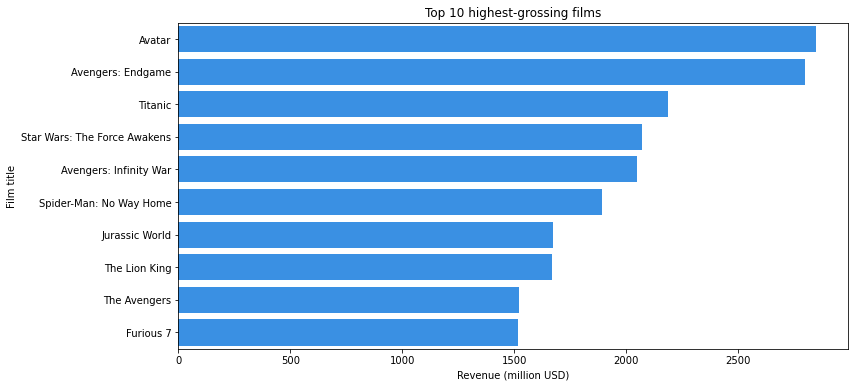

In [29]:
temp_df = df.sort_values(by='revenue', ascending=False).head(10)
temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000) 
plt.figure(figsize=(12,6))
sns.barplot(data=temp_df, y='original_title', x='revenue', color='dodgerblue')

plt.xlabel('Revenue (million USD)')
plt.ylabel('Film title')
plt.title("Top 10 highest-grossing films");

**Observation:** Avatar, Avengers: Endgame and Titanic took the top 3 positions for highest-grossing films.

In [30]:
#overview of the characteristics of the top 10 highest-grossing films
df.sort_values(by='revenue', ascending=False).head(10).drop(['genres','id','production_companies','production_countries','cast','crew','spoken_languages'],axis=1)

,budget,original_language,original_title,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,belongs_to_collection.name,genres_,production_companies_,production_countries_,spoken_languages_,cast_,director,release_year,release_month,top_50_production_companies,top_5_production_countries,top_5_spoken_languages,top_100_cast,top_20_directors,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
70,237000000,en,Avatar,561.301,2009-12-10,2847246203,162.0,Released,Avatar,7.5,25464,Avatar Collection,"Action,Adventure,Fantasy,Science Fiction","Dune Entertainment,Lightstorm Entertainment,20th Century...","United States of America,United Kingdom","English,Español","Sam Worthington,Zoe Saldana,Sigourney Weaver,Stephen Lan...",James Cameron,2009.0,12.0,3,2,2,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
141,356000000,en,Avengers: Endgame,325.730,2019-04-24,2797800564,181.0,Released,Avengers: Endgame,8.3,21085,The Avengers Collection,"Adventure,Science Fiction,Action",Marvel Studios,United States of America,"English,日本語,","Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemswor...",Anthony Russo,2019.0,4.0,0,1,2,8,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
380,200000000,en,Titanic,150.702,1997-11-18,2187463944,194.0,Released,Titanic,7.9,21041,NaN,"Drama,Romance","Paramount,20th Century Fox,Lightstorm Entertainment",United States of America,"English,Français,Deutsch,svenska,Italiano,Pусский","Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,Fr...",James Cameron,1997.0,11.0,2,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
645,245000000,en,Star Wars: The Force Awakens,104.428,2015-12-15,2068223624,136.0,Released,Star Wars: The Force Awakens,7.3,17017,Star Wars Collection,"Adventure,Action,Science Fiction,Fantasy","Lucasfilm Ltd.,Bad Robot",United States of America,English,"Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Dais...",J.J. Abrams,2015.0,12.0,0,1,1,4,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
77,300000000,en,Avengers: Infinity War,500.420,2018-04-25,2046239637,149.0,Released,Avengers: Infinity War,8.3,24642,The Avengers Collection,"Adventure,Action,Science Fiction",Marvel Studios,United States of America,"English,","Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,Chris Eva...",Anthony Russo,2018.0,4.0,0,1,1,7,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,200000000,en,Spider-Man: No Way Home,3512.757,2021-12-15,1892000000,148.0,Released,Spider-Man: No Way Home,8.1,13165,Spider-Man (Avengers) Collection,"Action,Adventure,Science Fiction","Marvel Studios,Pascal Pictures,Columbia Pictures",United States of America,"English,","Tom Holland,Zendaya,Benedict Cumberbatch,Jacob Batalon,J...",Jon Watts,2021.0,12.0,1,1,1,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
98,150000000,en,Jurassic World,424.027,2015-06-06,1671713208,124.0,Released,Jurassic World,6.7,17995,Jurassic Park Collection,"Action,Adventure,Science Fiction,Thriller","Amblin Entertainment,Legendary Pictures,Universal Pictur...",United States of America,English,"Chris Pratt,Bryce Dallas Howard,Ty Simpkins,Nick Robinso...",Colin Trevorrow,2015.0,6.0,4,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
328,260000000,en,The Lion King,167.905,2019-07-12,1667635327,118.0,Released,The Lion King,7.1,8446,The Lion King (Reboot) Collection,"Adventure,Family,Animation,Drama","Walt Disney Pictures,Fairview Entertainment",United States of America,English,"Chiwetel Ejiofor,John Oliver,James Earl Jones,John Kani,...",Jon Favreau,2019.0,7.0,1,1,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
133,220000000,en,The Avengers,343.025,2012-04-25,1518815515,143.0,Released,The Avengers,7.7,26958,The Avengers Collection,"Science Fiction,Action,Adventure",Marvel Studios,United States of America,"English,हिन्दी,Pусский","Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemswor...",Joss Whedon,2012.0,4.0,0,1,1,6,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
460,190000000,en,Furious 7,132.445,2015-04-01,1515

#### Film directors

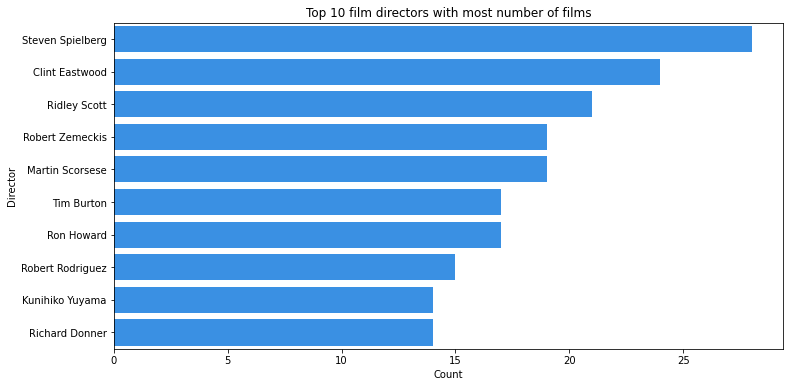

In [31]:
temp_df = pd.DataFrame(df['director'].value_counts(ascending=False)).reset_index()
temp_df.columns = ['Director','Count']

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df[:10], y='Director', x='Count', color='dodgerblue')
plt.title("Top 10 film directors with most number of films");

**Observation:** The horizontal barplot above shows the number of films the top 10 film directors produced. Steven Spielberg takes the top position by quite a margin as compared to Clint Eastwood who takes second position.

#### Top casts

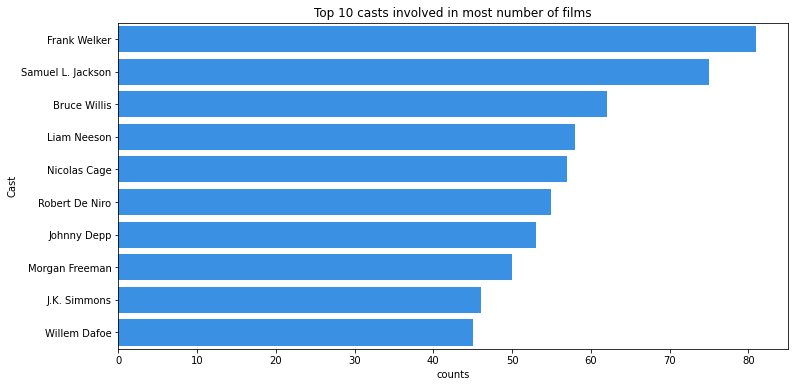

In [32]:
temp_df = pd.DataFrame(total_count(df,'cast',10),columns=['Cast','counts'])

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df, y='Cast', x='counts', color='dodgerblue')
plt.title("Top 10 casts involved in most number of films");

**Observation:** Taking the top 3 positions are Frank Welker, Samuel L. Jackson and Bruce Willis.

#### Genres

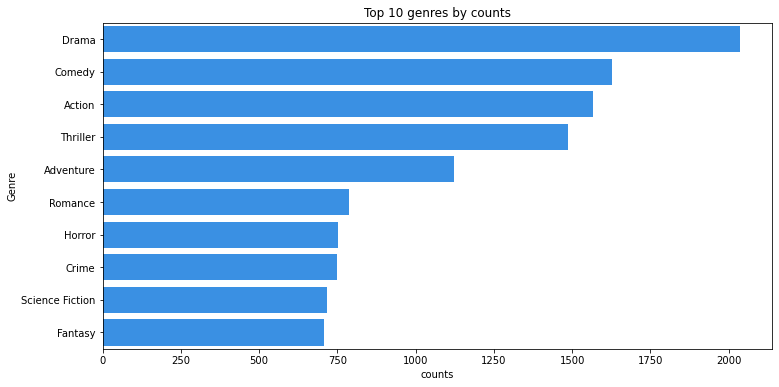

In [33]:
temp_df = pd.DataFrame(total_count(df,'genres',10),columns=['Genre','counts'])

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df, y='Genre', x='counts', color='dodgerblue')
plt.title("Top 10 genres by counts");

**Observation:** Drama, comedy and action take the top 3 most common genres in our dataset.

#### Production companies

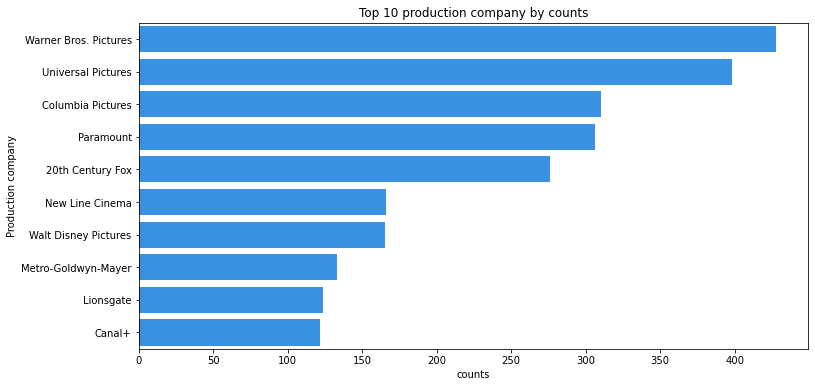

In [34]:
temp_df = pd.DataFrame(total_count(df,'production_companies', 10),columns=['Production company','counts'])

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df, y='Production company', x='counts', color='dodgerblue')
plt.title("Top 10 production company by counts");

**Observation:** Warner Bros. Pictures, Universal Pictures and Columbia Pictures take the top 3 positions for being involved in the most number of films.

#### Movie budget

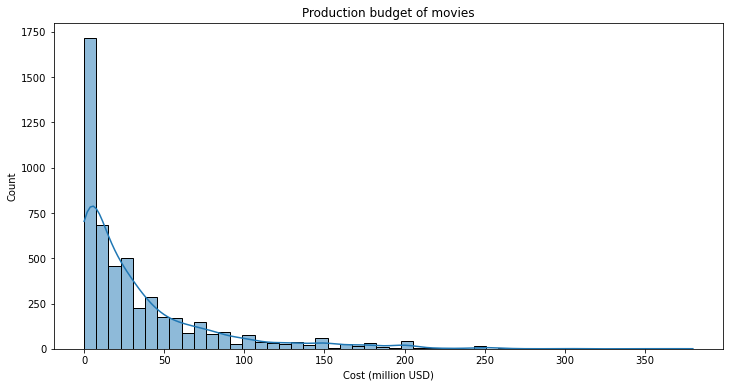

In [35]:
temp_df = df.copy()
temp_df['budget'] = temp_df['budget'].apply(lambda x: x/1_000_000)

plt.figure(figsize=(12,6))
sns.histplot(data=temp_df, x='budget', bins=50, kde=True)
plt.xlabel('Cost (million USD)')
plt.title("Production budget of movies");

**Observation:** From the histogram above, we observe that the distribution of the movies budget is right-skewed, and most of the movies in our dataset have a relatively lower budget.

#### Box office revenue

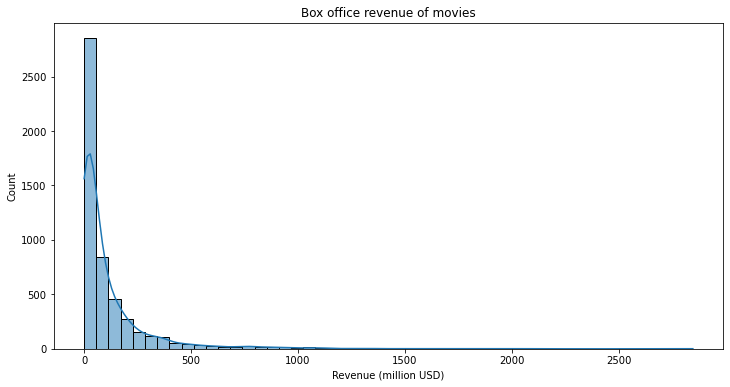

In [36]:
temp_df = df.copy()
temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000)

plt.figure(figsize=(12,6))
sns.histplot(data=temp_df, x='revenue', bins=50, kde=True)
plt.xlabel('Revenue (million USD)')
plt.title("Box office revenue of movies");

**Observation:** Again, we observe that the distribution of the box office revenue is right-skewed as well. We will compare the relationship between box office revenue and movie budget later on.

#### Popularity score

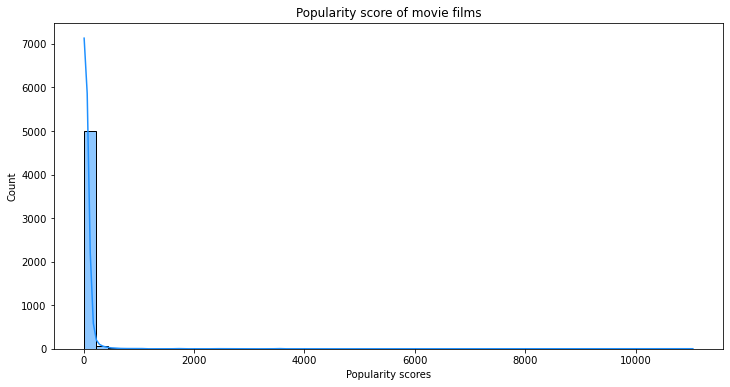

In [37]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='popularity', color='dodgerblue', kde=True, bins=50)
plt.xlabel('Popularity scores')
plt.title("Popularity score of movie films");

**Observation:** Again, we see a heavily right-skewed distribution for the popularity score of the movie films.

#### Film original language

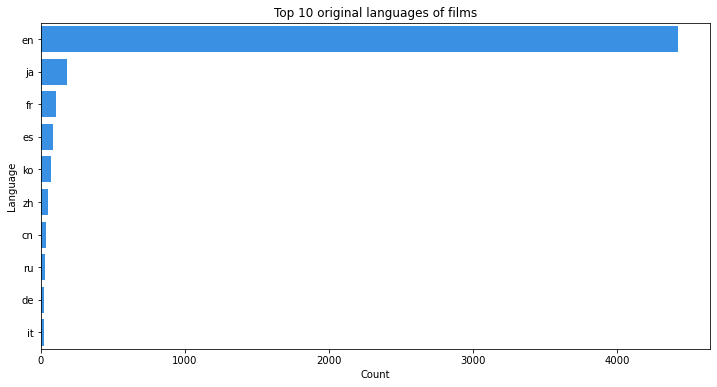

In [38]:
temp_df = pd.DataFrame(df['original_language'].value_counts(ascending=False)).reset_index()
temp_df.columns = ['Language','Count']

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df[:10], y='Language', x='Count', color='dodgerblue')
plt.title("Top 10 original languages of films");

**Observation:** Unexpectedly, english is the most common language of films, with a huge margin over the next 2 popular languages, japanese and french.

#### Movie runtime

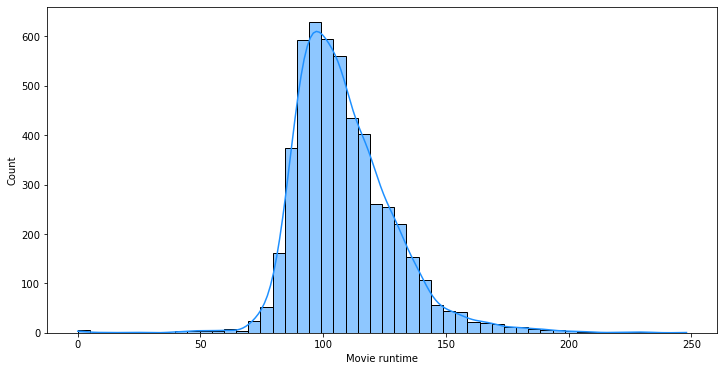

In [39]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='runtime', color='dodgerblue', kde=True, bins=50)
plt.xlabel("Movie runtime");

**Observation:** The distribution is slightly right-skewed for movie runtime.

#### Vote average

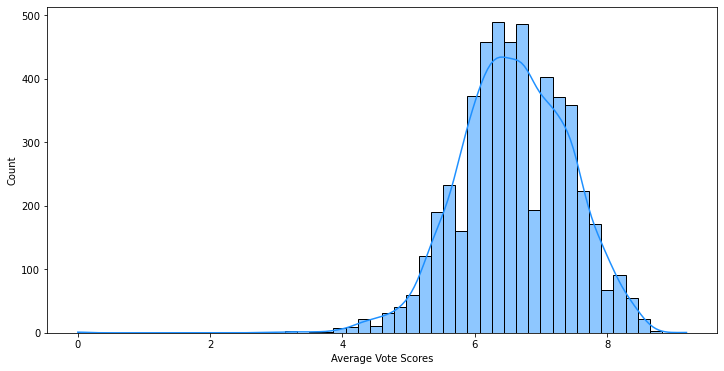

In [40]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='vote_average', color='dodgerblue', kde=True, bins=50)
plt.xlabel("Average Vote Scores");

**Observation:** The distribution is slightly left-skewed for average vote score, with some films receiving 0 or close to 0. Possible reasons include an absence of votes or skewed voting due to low vote counts.

#### Vote counts

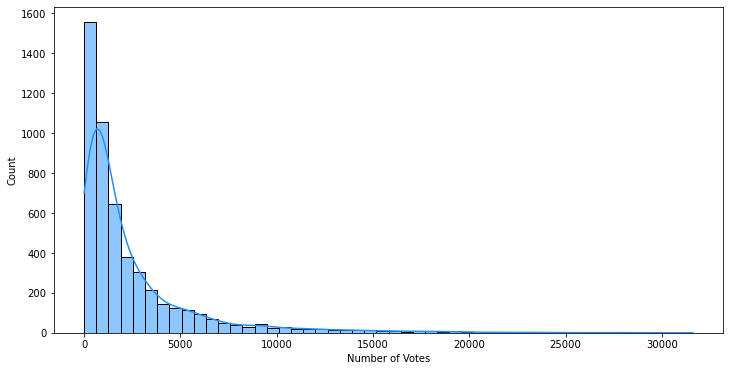

In [41]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='vote_count', color='dodgerblue', kde=True, bins=50)
plt.xlabel("Number of Votes");

**Observation:** The distribution is right-skewed for vote counts, possibly some films were highly popular/anticipated by fans and thus received many votes.

#### Number of films produced over the years

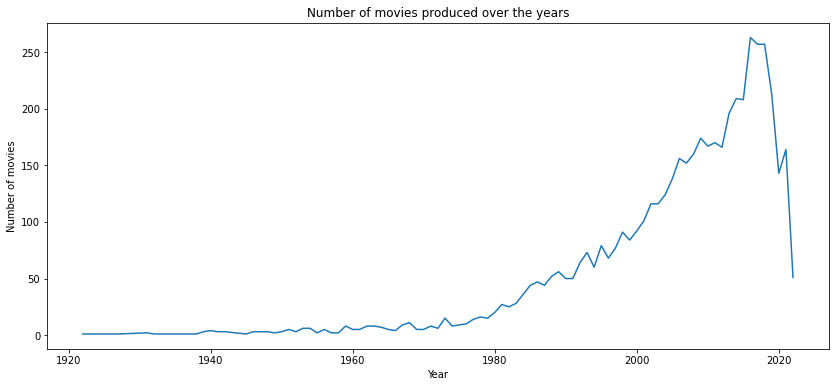

In [42]:
temp_df = df[['release_year','revenue']].groupby('release_year').count()

plt.figure(figsize=(14,6))
plt.plot(temp_df)
plt.xlabel('Year')
plt.ylabel("Number of movies")
plt.title("Number of movies produced over the years");

**Observation:** The number of films have risen exponentially in the recent years. The sharp drop in number of films from 2020 could possibly due to the sample size of our dataset and may not have contained movies that were more recently produced.

#### Seasonality of film release by month

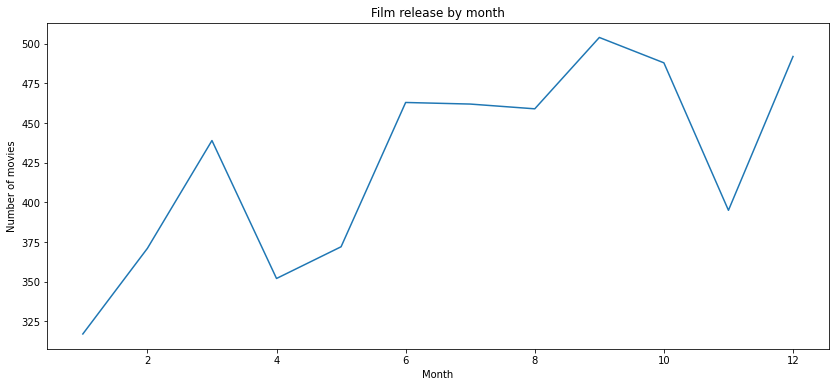

In [43]:
temp_df = df[['release_month','revenue']].groupby('release_month').count()

plt.figure(figsize=(14,6))
plt.plot(temp_df)
plt.xlabel('Month')
plt.ylabel("Number of movies")
plt.title("Film release by month");

**Observation:** There seems to be a seasonality trend where a greater number of movies were released in some months such as September, October and December, whereas January seems to be a lull period.

### Bivariate Analyses
#### Box office revenue and movie budget

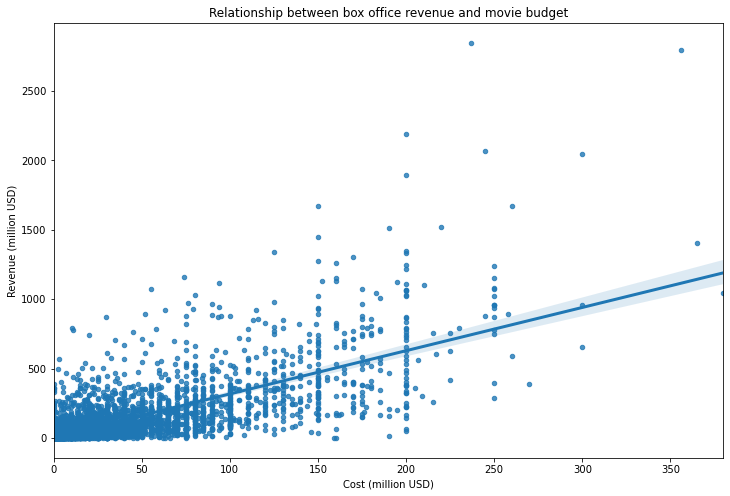

In [44]:
temp_df = df.copy()
temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000)
temp_df['budget'] = temp_df['budget'].apply(lambda x: x/1_000_000)

plt.figure(figsize=(12,8))
sns.regplot(data=temp_df, x='budget', y='revenue', scatter_kws={"s": 20}, line_kws={'lw':3})

plt.xlabel('Cost (million USD)')
plt.ylabel('Revenue (million USD)')
plt.title("Relationship between box office revenue and movie budget");

**Observation:** There seems to be some positive correlation between box office revenue and movie budget, which makes sense since a movie is likely to be more phenomenal if bigger budget can allocated for the film production for various purposes, such as hiring A-listers.

#### Popularity score and revenue

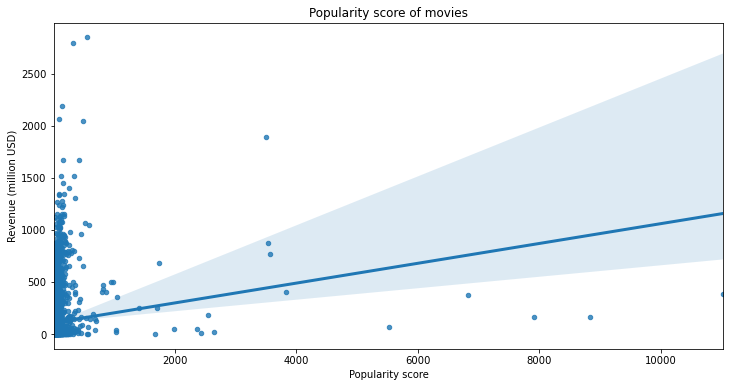

In [45]:
temp_df = df.copy()
temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000)

plt.figure(figsize=(12,6))
sns.regplot(data=temp_df, x='popularity',y='revenue',scatter_kws={"s": 20}, line_kws={'lw':3})

plt.xlabel('Popularity score')
plt.ylabel('Revenue (million USD)')
plt.title("Popularity score of movies");

**Observation:** The relationship between popularity score and revenue does not seem to be very strong. Previously we also note the popularity score ranges very widely. According to the TMDB website, the popularity score are determined by many factors that are determined by TMDB [(source)](https://developers.themoviedb.org/3/getting-started/popularity). To prevent any bias, we will not use this feature for modelling purposes.

#### Average vote score and vote counts

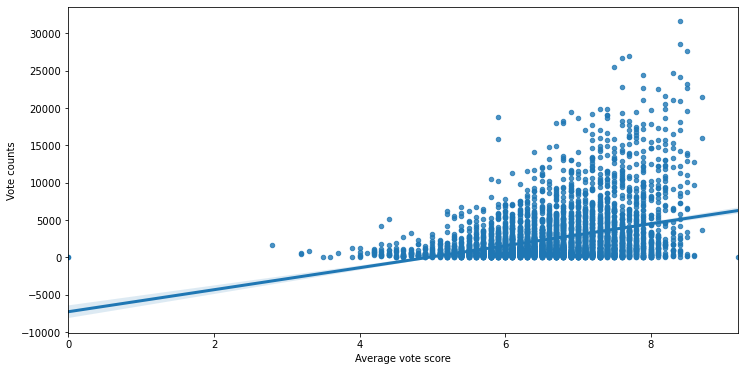

In [46]:
plt.figure(figsize=(12,6))
sns.regplot(data=df, x='vote_average',y='vote_count',scatter_kws={"s": 20}, line_kws={'lw':3})
plt.xlabel('Average vote score')
plt.ylabel("Vote counts");

**Observation:** This may not be a good visualization, but we can still make out a positive correlation between vote counts and average vote score.

#### Movie runtime and revenue

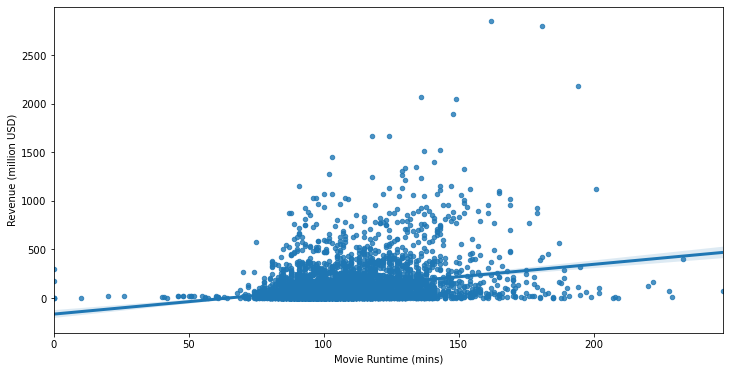

In [47]:
temp_df = df.copy()
temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000)

plt.figure(figsize=(12,6))
sns.regplot(data=temp_df, x='runtime',y='revenue',scatter_kws={"s": 20}, line_kws={'lw':3})

plt.xlabel('Movie Runtime (mins)')
plt.ylabel('Revenue (million USD)');

**Observation:** There does not seem to be any obvious relationship between movie runtime and revenue. Also, there are many films that are below 50 minutes in length, which is below the most films' duration. There might be erroneous data in this feature and so we will not include this feature in our modelling.

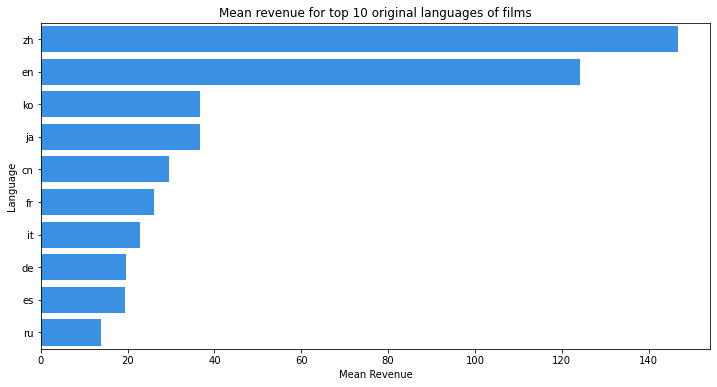

In [48]:
top10lang = df['original_language'].value_counts()[:10].index.tolist()
temp_df = df[df['original_language'].isin(top10lang)][['original_language','revenue']]

temp_df['revenue'] = temp_df['revenue'].apply(lambda x: x/1_000_000)

temp_df = temp_df.groupby('original_language').mean().sort_values(by='revenue', ascending=False).reset_index()
temp_df.columns = ['Language','Mean Revenue']

plt.figure(figsize=(12,6))
sns.barplot(data=temp_df, y='Language', x='Mean Revenue', color='dodgerblue')
plt.title("Mean revenue for top 10 original languages of films");

**Observation:** It is clear that films in mandarin and english languages tend to have the highest box office revenue, possibly due to these languages being the most widely spoken and understood. It is also worth noting that zh and cn both refer to mandarin language. We can perhaps create new variables as english, mandarin or others.

## Data Cleaning-2

#### Drop all unnecessary columns

In [49]:
df = df.drop(['genres',
              'id',
              'production_companies',
              'production_countries',
              'spoken_languages',
              'cast',
              'crew',
              'original_title',
              'title',
              'genres_',
              'production_companies_',
              'production_countries_',
              'spoken_languages_',
              'cast_',
              'release_date',
              'director'],
                  axis=1)

In [50]:
df.isnull().sum()[df.isnull().sum()>0]

belongs_to_collection.name    3498
release_year                     1
release_month                    1
dtype: int64

#### Feature engineer `years_released`

In [51]:
df['years_released'] = df['release_year'].apply(lambda x: 2022-x)

#### Drop `release_year` and `release-month` columns

In [52]:
# drop years and months columns
df = df.drop(['release_month', 'release_year'], axis=1)

#### Drop columns with high null values

In [53]:
df = df.drop('belongs_to_collection.name', axis=1)

#### Drop `popularity` column

In [54]:
df = df.drop('popularity', axis=1)

#### Drop rows with null values

In [55]:
df = df.dropna(axis=0)

#### Reclassify variables for `original_language` column

In [56]:
df['original_language'] = df['original_language'].map({'en':'English', 'cn':'Mandarin', 'zh':'Mandarin'})
df['original_language'] = df['original_language'].fillna('Others')

#### Drop columns with low variance

In [57]:
df['status'].value_counts()

Released    5114
Name: status, dtype: int64

In [58]:
df = df.drop('status', axis=1)

#### Drop outliers

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,5114.0,3.432243e+07,4.559202e+07,0.0,3500000.0,18000000.0,4.500000e+07,3.800000e+08
revenue,5114.0,1.125037e+08,1.949089e+08,1.0,11066226.0,44146340.0,1.279438e+08,2.847246e+09
runtime,5114.0,1.085383e+02,2.043110e+01,0.0,95.0,105.0,1.190000e+02,2.480000e+02
vote_average,5114.0,6.599374e+00,8.255382e-01,0.0,6.1,6.6,7.200000e+00,9.200000e+00
vote_count,5114.0,2.451502e+03,3.360341e+03,0.0,515.0,1224.0,2.908750e+03,3.160700e+04
top_50_production_companies,5114.0,9.260853e-01,8.959195e-01,0.0,0.0,1.0,1.000000e+00,6.000000e+00
top_5_production_countries,5114.0,1.143136e+00,6.644303e-01,0.0,1.0,1.0,1.000000e+00,5.000000e+00
top_5_spoken_languages,5114.0,1.201995e+00,5.800550e-01,0.0,1.0,1.0,1.000000e+00,5.000000e+00
top_100_cast,5114.0,7.238952e-01,1.167737e+00,0.0,0.0,0.0,1.000000e+00,1.100000e+01
top_20_directors,5114.0,6.140008e-02,2.400862e-01,0.0,0.0,0.0,0.000000e+00,1.000000e+00


In [60]:
def remove_outliers(df, col):
    lower_bound = df[col].quantile(0.01)
    higher_bound  = df[col].quantile(0.99)

    df = df[(df[col] < higher_bound) & (df[col] > lower_bound)]
    return df

In [61]:
df = remove_outliers(df,'budget')
df = remove_outliers(df,'revenue')
df = remove_outliers(df,'runtime')
df = remove_outliers(df,'vote_count')

#### Convert features to correct datatypes 

In [62]:
df['runtime'] = df['runtime'].astype(int)

#### Check for multicollinearity within features

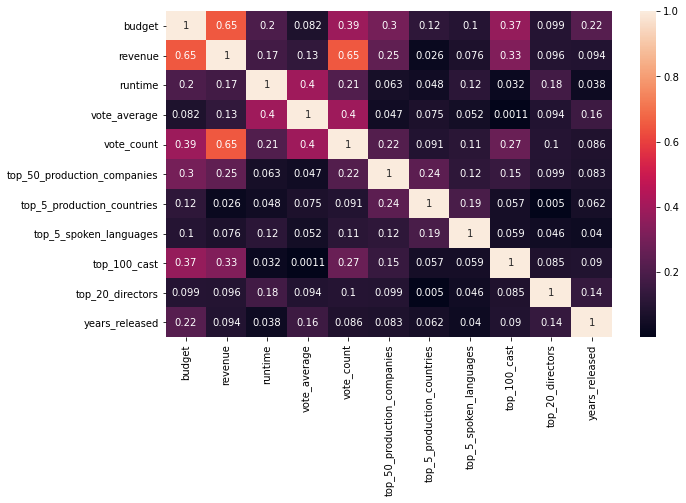

In [63]:
#check for multicollinearity
## ont-hot encoded genres columns not analyzed as they were originally categorical columns

temp_df = pd.concat([df.iloc[:,:11],df.iloc[:,-1:]],axis=1)
temp_df.head()
plt.figure(figsize=(10,6))
sns.heatmap(temp_df.corr().abs(), annot=True);

There are no multicollinearity within predictor variables. We can proceed with modelling on this dataset.

In [64]:
df.shape

(3902, 31)

## Export cleaned dataset

In [66]:
# df.to_csv('../data/cleaned_df', index=False)